In [1]:
import math

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


jax.config.update("jax_enable_x64", True)

Try a very simple problem formulation. 

$q(x) = (x_1 + 1)^2 + (x_2 + 1)^2 = x_1^2 + 2 x_1 + 1 + x_2^2 + 2 x_2 + 1 = x^T \mathbb{I}_2 x + [2, 2]^T x + 2$


With a symmetric paraboloid, the Hessian of the target function is always a (scaled) identity.

$\min x^T \mathbb{I}_2 x + c^Tx + 2 \\ s.t. \quad x_1^2 + x_2^2 = 1 $

The constraint Jacobian is

$[2 x_1, 2 x_2]$

And the Hessian is $2 \cdot \mathbb{I}_2$.

At $(1, 0)$, the gradient $\nabla f$ is $ 2 \cdot \mathbb{I}_2 \cdot [1, 0]^T + [2, 2]^T = [4, 2]^T$. 
The constraint evaluation is satisfied, so we have that $c(x) = 1$.
The constraint Jacobian at this point is $[2, 0]$.

With the KKT system (for a quadratic problem)

$$
\begin{bmatrix}
H & -A^T \\
A & 0
\end{bmatrix}
\begin{bmatrix}
\Delta x \\
\Delta \lambda
\end{bmatrix}
=
\begin{bmatrix}
-\nabla f + A^T \lambda \\
b - A(x)
\end{bmatrix}
$$

when the constraints are nonlinear, we still have to approximate them linearly, in order to construct the KKT system.
However, we can use the nonlinear expression on the right-hand-side to get

$$
\begin{bmatrix}
H & -A^T \\
A & 0
\end{bmatrix}
\begin{bmatrix}
\Delta x \\
\Delta \lambda
\end{bmatrix}
=
\begin{bmatrix}
-\nabla f + A^T \lambda \\
b - c(x)
\end{bmatrix}
$$

Substituting the known values, we get the system 

$$
\begin{bmatrix}
2 & 0 & -2 \\
0 & 2 & 0 \\
2 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
\Delta x_1 \\
\Delta x_2 \\
\Delta \lambda
\end{bmatrix}
=
\begin{bmatrix}
-4 + 2 \cdot \lambda \\
-2 + 0 \cdot \lambda\\
1 - 1
\end{bmatrix}
=  
\begin{bmatrix}
-4 + 2 \cdot \lambda \\
-2 \\
0 
\end{bmatrix}
$$

which allows us to cancel out the factor of $2$.

$$
\begin{bmatrix}
1 & 0 & -1 \\
0 & 1 & 0 \\
1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
\Delta x_1 \\
\Delta x_2 \\
\Delta \lambda
\end{bmatrix}
=  
\begin{bmatrix}
-2 + \lambda \\
-1 \\
0 
\end{bmatrix}
$$

Now suppose that the dual variables have not yet converged, and we don't know the value of the multiplier $\lambda$.
We can still solve this by Gauss-Jordan to get

$$ 
\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
\Delta x_1 \\
\Delta x_2 \\
\Delta \lambda
\end{bmatrix}
= 
\begin{bmatrix}
2 - \lambda \\
-1 \\
0 
\end{bmatrix}
$$

which we could re-order, but don't have to. The solution is 

$\Delta x_1 = 2 - \lambda; \, \Delta x_2 = -1; \, \Delta \lambda = 0$

The direction therefore depends on the value of the multiplier. Suppose that we have that $\lambda = 2$, in which case we take a unit step in $-x_2$.
If we took a full step, we would immediately leave the circle.
To compute the second order correction in IPOPT, we add the constraint evaluation at the proposed next (feasible) step.

At $[1, 0]^T + [0, -1]^T = [1, -1]^T$ the constraint value is $2$, when it should be $1$. So the updated linear system is

$$
\begin{bmatrix}
2 & 0 & -2 \\
0 & 2 & 0 \\
2 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
\Delta x_1 \\
\Delta x_2 \\
\Delta \lambda
\end{bmatrix}
=
\begin{bmatrix}
-4 + 2 \cdot \lambda \\
-2 + 0 \cdot \lambda\\
1 - 1 - 2
\end{bmatrix}
=  
\begin{bmatrix}
-4 + 2 \cdot \lambda \\
-2 \\
-2
\end{bmatrix}
$$

here, we can still factor out $2$ and get

$$
\begin{bmatrix}
1 & 0 & -1 \\
0 & 1 & 0 \\
1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
\Delta x_1 \\
\Delta x_2 \\
\Delta \lambda
\end{bmatrix}
=
\begin{bmatrix}
-2 + \lambda \\
-1 \\
-1
\end{bmatrix}
$$

which results in 

$$
\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
\Delta x_1 \\
\Delta x_2 \\
\Delta \lambda
\end{bmatrix}
=
\begin{bmatrix}
1 - \lambda \\
-1 \\
-1
\end{bmatrix}
$$

Suppose that we still have $\lambda = 2$, then we get

$\Delta x_1 = 1 - 2 = -1; \, \Delta x_2 = -1; \, \Delta \lambda = -1$


In [2]:
def paraboloid(x, y):
    return 0.5 * (x + 1) ** 2 + 0.5 * (y + 1) ** 2


# Constraint defined with inequalities -> what does that mean for the linear
# independence of the constraint Jacobian? This is how it would ordinarily be
# implemented, but it seems as though that might not be what is happening in IPOPT.
def constraint(x, y):
    c1 = x**2 + y**2 - 1  # One sided: circle with radius >= 1
    # c2 = 1 - x**2 - y**2  # One sided: circle with radius <= 1
    return c1  # , c2

In [3]:
def make_plot():
    # Make contour plot
    limits = (-2.3, 3)
    x = jnp.linspace(*limits, 100)
    y = jnp.linspace(*limits, 100)
    X, Y = jnp.meshgrid(x, y)
    Z = paraboloid(X, Y)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.contourf(X, Y, Z, levels=20, alpha=0.5, cmap="Grays", vmin=0, vmax=10)

    # Add constraint: circle centered at the origin
    circle = plt.Circle((0, 0), 1, color="olive", fill=False, label="Constraint")
    ax.add_patch(circle)

    # Layouting
    ticks = jnp.linspace(*[math.floor(l) for l in limits], 5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Paraboloid with constraint")

    return fig, ax

(Array(2., dtype=float64), Array(0., dtype=float64))


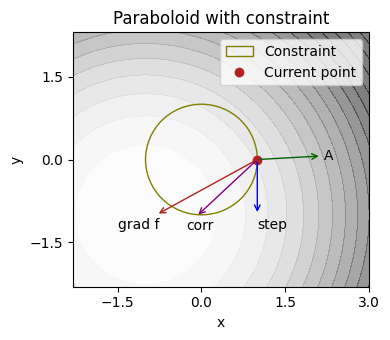

In [4]:
fig, ax = make_plot()

# Add current point
current_point = jnp.array([1.0, 0.0])
ax.plot(*current_point, "o", color="firebrick", label="Current point")

# Add gradient of current point
gradient = jax.grad(paraboloid, argnums=(0, 1))(*current_point)
descent = -jnp.asarray(gradient)
tip = current_point + 1.25 * descent
props = dict(arrowstyle="<-", color="firebrick")
ax.annotate("grad f", xytext=tip, xy=current_point, arrowprops=props)

# Add constraint Jacobian
constraint_jacobian = jax.jacfwd(constraint, argnums=(0, 1))(*current_point)
tip = current_point + 0.6 * jnp.asarray(constraint_jacobian)
props = dict(arrowstyle="<-", color="darkgreen")
ax.annotate("A", xytext=tip, xy=current_point, arrowprops=props)
print(constraint_jacobian)

# Proposed step if lambda = 2
step = jnp.array([0, -1.0])
tip = current_point + 1.25 * step
props = dict(arrowstyle="<-", color="blue", relpos=(0.0, 0.5))
ax.annotate("step", xytext=tip, xy=current_point, arrowprops=props)

# Corrected step
corrected_step = jnp.array([-1.0, -1])
tip = current_point + 1.28 * corrected_step
props = dict(arrowstyle="<-", color="purple", relpos=(0.0, 0.5))
ax.annotate("corr", xytext=tip, xy=current_point, arrowprops=props)

# Finishing touches
ax.legend()
ax.set_ylim(-2.3, 2.3)
# fig.suptitle("Illustration of second-order correction")
fig.set_size_inches(4, 3.5)
fig.tight_layout()
fig.savefig("second_order_correction.png")

So during the second-order correction, the magnitude of the step can actually change.
Including the scalar (max feasible) step size seems to be an implementation detail - not sure if this is even required.
By modifying just the constraint portion of the right-hand-side, we essentially rotate through descent directions.
This has to be done in a while loop, since the constraint violation that we are adding to the right-hand side should decrease (superlinearly if the problem is reasonably well behaved). This allows us to integrate the change a measure of nonlinearity of the constraint function into the KKT system.

I actually like it. It will be hard to implement, but I do like it.

In [5]:
# Two notes: we need to fail much more gracefully when it comes to typing of constraint
# functions!
# I should test-drive the whole library with mis-specified constraints to figure out
# where on the spectrum from terrifying to useful our errata land.

# More urgently, I apparently get an error when no bounds are specified with the
# IPOPTLike solver, and that is the last thing that should be happening.

In [6]:
def parabolic_objective(y, args):
    del args
    x1, x2 = y
    return 0.5 * (x1 + 1) ** 2 + 0.5 * (x2 + 1) ** 2


def constraint(y):
    x1, x2 = y
    return x1**2 + x2**2 - 1, None


import optimistix as optx


solver = optx.IPOPTLike(rtol=1e-3, atol=1e-6)
y0 = jnp.array([1.0, 0.0])
bounds = (jnp.array([-10.0, -10.0]), jnp.array([10.0, 10.0]))
solution = optx.minimise(
    parabolic_objective,
    solver,
    y0,
    constraint=constraint,
    bounds=bounds,
    max_steps=10,
    throw=False,
)

solution.value, solution.result == optx.RESULTS.successful

final iterate: (Array([-0.70715518, -0.70705842], dtype=float64), (Array(0.20568542, dtype=float64), None), (Array([0.0010761 , 0.00107609], dtype=float64), Array([0.00093398, 0.00093393], dtype=float64)))


(Array([-0.70698921, -0.70722456], dtype=float64), Array(False, dtype=bool))

In [7]:
jax.grad(parabolic_objective)(solution.value, None)

Array([0.29301079, 0.29277544], dtype=float64)

In [8]:
equality_jac, inequality_jac = jax.jacfwd(constraint)(solution.value)

0.20710678 * equality_jac

Array([-0.29284452, -0.292942  ], dtype=float64)

In [9]:
trajectory = jnp.array(
    [
        [1.0, 0.0],
        [1.0, -1.0],
        [-0.25, -1.75],
        [-1.005, -1.035],
        [-0.75886036, -0.75166216],
        [-0.70726875, -0.71004546],
        [-0.70768477, -0.70653715],
        [-0.70686953, -0.70734488],
        [-0.7072053, -0.7070084],
        [-0.70706601, -0.70714757],
    ]
)

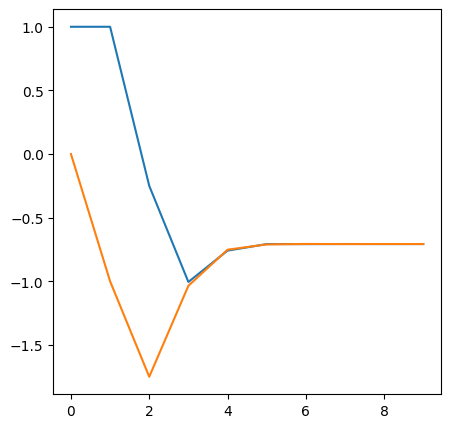

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

iterations, _ = trajectory.shape
ax.plot(jnp.arange(iterations), trajectory[:, 0], label="x1")
ax.plot(jnp.arange(iterations), trajectory[:, 1], label="x2")

In [11]:
rescued = jnp.array([0.66088046, -0.75049118])

parabolic_objective(rescued, None), constraint(rescued)

(Array(1.41038928, dtype=float64),
 (Array(-6.33239594e-09, dtype=float64), None))

In [12]:
parabolic_objective(y0, None), constraint(y0)

(Array(2.5, dtype=float64), (Array(0., dtype=float64), None))

In [13]:
intermediate = jnp.array([1, -1.0])

parabolic_objective(intermediate, None), constraint(intermediate)

(Array(2., dtype=float64), (Array(1., dtype=float64), None))

At the rescued point, the parabolic objective has a better value than at any previously accepted point (counting the start), although the constraint function has a slightly worse value.

I wonder why we we can't move on from this point - could it be that this is because we have seen better values for the target function, even though they had much higher constraint violations? And also have seen one point without any constraint violation? 

Because the restored point sure seems good. It is on the circle, or very near it.

With an OR gate for the filter, we might never accept such a restored step - and it running into such a situation may be as easy as taking a bad first step.

In [14]:
A, _ = jax.jacfwd(constraint)(y0)

-0.5 * A + jax.grad(parabolic_objective)(y0, None)

Array([1., 1.], dtype=float64)

In [15]:
# Ok, this is a problem. Because I have not figured out how to handle the updates to the
# dual variables and hotfixed this part, I actually introduced a bug in the code - the
# duals now get updated even thought the descent has not been queried at all.

# Restoring feasibility also does not help on this trivial problem, it just puts us back
# to where we already were.

# So what happens here is that:
# 1. We're using a not-quite correct Hessian - just the BFGS approximation to the target
# function, without considering the constraints. This means that the Hessian of the
# Lagrangian is not actually correct. The question here is what to do about this -
# either to write up a quasi Newton approximation for the Hessian of the Lagrangian,
# with an SLSQP-like update, or some other hotfix that treats the constraint Hessian as
# an additive thing. This might contribute to getting such a weird initial direction
# here. (Check if I have accounted for this above.)
# -> In the special case above, we have that Hess(f) = I, and Hess(c) = 2 I. So, if we
# assume that these are additive, then we get that Hess(L) = 3 I.

# 2. For whatever reason (figure out why), the first time we query the descent actually
# returns an almost-nil step. The search does not seem to accept this step, except for
# the first iteration (and why? Special case or actual improvement?). Since we don't get
# any improvement, the search rejects all subsequent steps and then triggers a restore.
# However, the restoration puts us back to the original point, since it is both closest
# and feasible. (This does not match my analytic result above.)
# 3. I need to think more carefully about special-casing the first step here. In this
# case, I actually want to be able to trigger a second-order correction at the first
# step too? The whole point of special-casing the first step is ensure that we get some
# movement, I think?
# 4. We get spurious updates to the duals since we do not update these via the
# descent.step.

# Next steps: figure out exactly what the descent computes, and why it does not match
# what we have above (the analytic solution)
# Make sure that it all makes sense - including the updates to the dual variables -
# before adding any extra complexity with the second order correction. The latter will
# include updated descent states, so everything else has to be in place before, I'm
# afraid.